# 2.3 Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

## 2.3.1 Least Squares

In [54]:
ORANGE = 1
BLUE = 0

def generate_data(n_samples: int) -> tuple:
    means_blue = np.random.multivariate_normal([1, 0], np.eye(2), 10)
    means_orange = np.random.multivariate_normal([0, 1], np.eye(2), 10)
    n_blue = int(n_samples / 2)
    n_orange = n_samples - n_blue
    
    blue_samples = np.zeros((n_blue, 2))
    orange_samples = np.zeros((n_orange, 2))
    
    for i in range(n_blue):
        mean_i = means_blue[np.random.choice(np.arange(means_blue.shape[0])), :]
        blue_samples[i, :] = np.random.multivariate_normal(mean_i, np.eye(2)/5, 1)
        
    for i in range(n_orange):
        mean_i = means_orange[np.random.choice(np.arange(means_orange.shape[0])), :]
        orange_samples[i, :] = np.random.multivariate_normal(mean_i, np.eye(2)/5, 1)
        
    X = np.vstack((blue_samples, orange_samples))
    Y = np.append(np.repeat(BLUE, n_blue), np.repeat(ORANGE, n_orange)).reshape(-1, 1)
    return X, Y

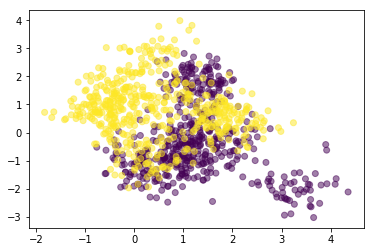

In [55]:
X, Y = generate_data(1000)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y.flatten(), alpha=0.5)
plt.show()

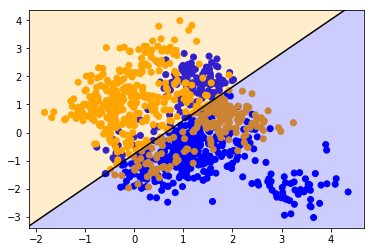

In [56]:
def linear_regression(X, Y):
    X_with_one = np.hstack((np.ones((X.shape[0], 1)), X))
    beta_pred = np.linalg.inv(X_with_one.T.dot(X_with_one)).dot(X_with_one.T).dot(Y)
    return beta_pred


def decision_boundary(y, boundary=0.5):
    if y > boundary:
        return ORANGE
    else:
        return BLUE

def plot_decision_boundary(boundary, beta_pred, ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    lsq_ymin = (boundary - beta_pred[0] - beta_pred[1]*xmin) / beta_pred[2]
    lsq_ymax = (boundary - beta_pred[0] - beta_pred[1]*xmax) / beta_pred[2]
    ax.plot([xmin, xmax], [lsq_ymin, lsq_ymax], color='black')
    ax.fill_between([xmin, xmax], [ymin], [lsq_ymin, lsq_ymax], alpha=0.2, facecolor='blue')
    ax.fill_between([xmin, xmax], [lsq_ymin, lsq_ymax], [ymax], alpha=0.2, facecolor='orange')
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))


ax = plt.subplot(111)
colors = ['blue' if x == BLUE else 'orange' for x in Y]
ax.scatter(X[:, 0], X[:, 1], c=colors)
beta_pred = linear_regression(X, Y).flatten()
plot_decision_boundary(0.5, beta_pred, ax)
plt.show()

## 2.3.2 Nearest Neighbors

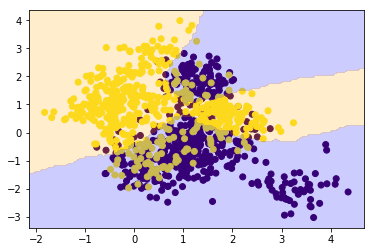

In [74]:
def knn(x, X, Y, k):
    d_x = np.sqrt(np.sum((X - x)**2, axis=1))    
    sorted_idxs = np.argsort(d_x)
    top_k_idxs = sorted_idxs[:k]
    top_k_ys = Y[top_k_idxs].flatten()
    
    score = (1/k)*(np.sum(top_k_ys))
    return score

def plot_knn_boundaries(X, Y, k, ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    xx = np.linspace(start=xmin, stop=xmax, num=100)
    yy = np.linspace(start=ymin, stop=ymax, num=100)
        
    X_grid, Y_grid = np.meshgrid(xx, yy)
    
    Z_grid = np.zeros_like(X_grid)
    
    for i in range(X_grid.shape[0]):
        for j in range(X_grid.shape[1]):
            v = np.array([X_grid[i, j], Y_grid[i, j]])
            z = knn(v, X, Y, k)
            Z_grid[i, j] = decision_boundary(z)
    ax.contourf(X_grid, Y_grid, Z_grid, 1, alpha=0.2, colors=['blue', 'orange'])

ax = plt.subplot(111)
colors = ['blue' if x == BLUE else 'orange' for x in Y]

ax.scatter(X[:, 0], X[:, 1], c=Y.flatten())
plot_knn_boundaries(X, Y, 100, ax)
plt.show()

## 2.3.3 From least squares to nearest neighbors

In [85]:
X_train, Y_train = generate_data(100)
X_test, Y_test = generate_data(10000)

In [86]:
def predict(X_test, X_train, Y_train, K):
    Y_pred = np.zeros((X_test.shape[0], 1), dtype=int)
    for i in range(X_test.shape[0]):
        Y_pred_i = decision_boundary(knn(X_test[i, :], X_train, Y_train, K))
        Y_pred[i] = Y_pred_i
    return Y_pred

In [87]:
def test_error(Y_test, Y_pred):
    equal = (Y_pred == Y_test).sum()
    different = Y_pred.shape[0] - equal
    return different / (Y_pred.shape[0])

In [88]:
test_errors = []
train_errors = []

for k in tqdm(range(1, 150)):
    Y_pred_test_k = predict(X_test, X_train, Y_train, k)
    test_errors.append(test_error(Y_test, Y_pred_test_k))
    
    Y_pred_train_k = predict(X_train, X_train, Y_train, k)
    train_errors.append(test_error(Y_train, Y_pred_train_k))

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:40<00:00,  3.76it/s]


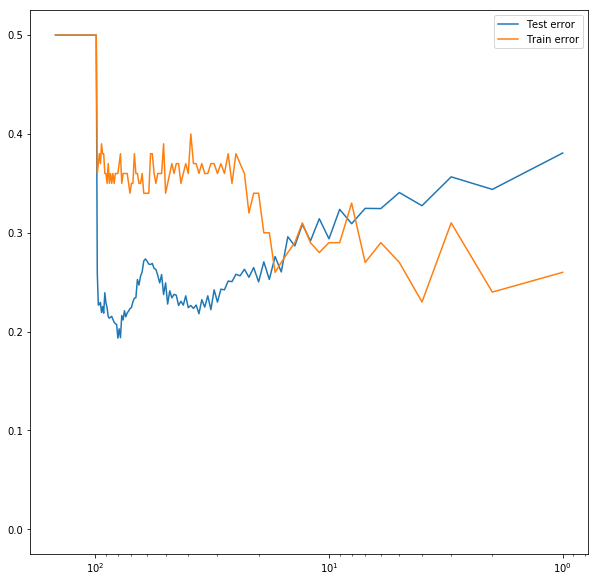

In [89]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(test_errors, label="Test error")
ax.plot(train_errors, label="Train error")
ax.invert_xaxis()
ax.set_xscale("log")
ax.legend()
plt.show()